In [2]:
import autograd.numpy as np
from autograd import grad, hessian
import colorsys
import json
import matplotlib.pyplot as plt
import numpy as np2
from numpy.random import multivariate_normal as mvn
import pandas as pd
import random as ran
import ternary
%matplotlib inline

from scipy.optimize import minimize
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Set up tag dataset

In [3]:
class tagClass:
    """Class to store each tag coordinate data."""
    def __init__(self, data: dict, tClass):
        self.x = data.get("x")
        self.y = data.get("y")
        self.fn = data.get("fn").removeprefix("40data/")
        self.label = data.get("label")
        self.tagX, self.tagX2, self.tagY, self.tagY2 = self.getSnip()
        self.tagClass = tClass
    
    # Get functions
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getFn(self):
        return self.fn
    def getLabel(self):
        return self.label
    def getFileClass(self):
        return tagClass
    
    # Returns coordinates for 16 x 16 crop around tag centre
    def getSnip(self):
        s = 16
        newX = self.x-(s/2)
        if newX%2 != 0:
            newX -= 1
        newY = self.y-(s/2)
        if newY%2 != 0:
            newY -= 1
        return int(newX), int(newX+s), int(newY), int(newY+s)
    
    def getSnipCoords(self):
        return self.tagX, self.tagX2, self.tagY, self.tagY2

In [4]:
# Load data from JSON for 40 tags at 15m (multiple images)
raw15 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_15m.json"))

In [5]:
def getTags(rawData, nType):
    """Process raw data into objects of Tag class."""
    listData = []
    for n in nType:
        for i in rawData[n]:
            i = dict(i)
            d = tagClass(i, n)
            listData.append(d)
    return listData

In [6]:
def getPhoto(tag: tagClass):
    """Returns the image this tag is from."""
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo

In [7]:
def getSnipPlot(tag):
    """Return a 16 x 16 pixel crop in the image for this tag."""
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo[tagY:tagY2,tagX:tagX2].astype(np.float32)

In [8]:
def getBayer(x, y):
    """Find Bayer filter pixel colour for given coordinate."""
    if x%2 == 0:
        if y%2 == 0:
            return "R" #RGGB
        else:
            return "G" #GBRG
    else:
        if y%2 == 0:
            return "G" #GRBG
        else:
            return "B" #BGGR

In [9]:
def getPixels(t: tuple, photo):
    """Returns RGB values for this tag as ratio."""
    tagX, tagX2, tagY, tagY2 = t
    red = 0
    green = 0
    blue = 0
    for px in range(tagX, tagX2):
        for py in range(tagY, tagY2):
            col = getBayer(py, px)
            if col == 'R':
                red += int(photo[py, px])
            elif col == 'G':
                green += int(photo[py, px])
            else:
                blue += int(photo[py, px])
    totalSum = red + (0.5*green) + blue
    return red/totalSum, (0.5*green)/totalSum, blue/totalSum

In [10]:
tags = getTags(raw15['0'], ['649', '655', '657', '659', '661', '669', '671'])
allTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in tags:
    # Get data for each tag in data
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    allTags.loc[len(allTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

Text(0, 0.5, 'Pixels')

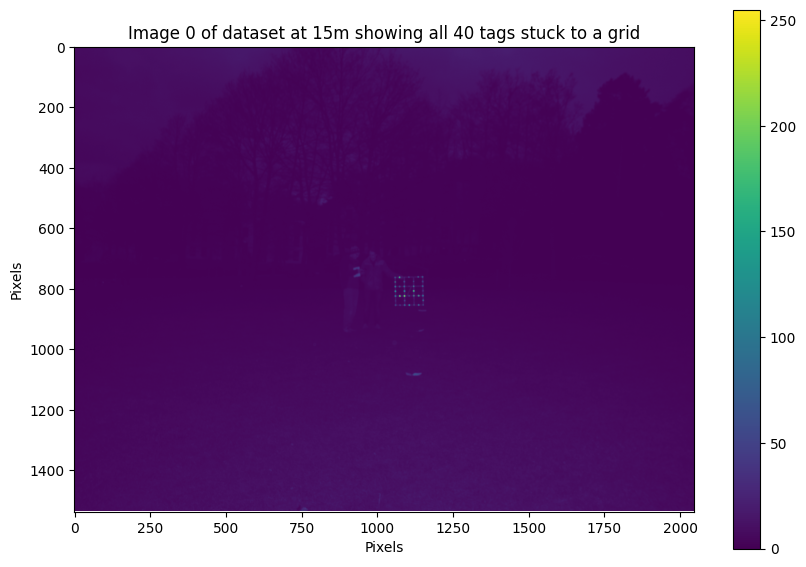

In [116]:
plt.figure(figsize=(10,7))
plt.imshow(getPhoto(allTags['Tag'][0]))
plt.colorbar()
plt.title("Image 0 of dataset at 15m showing all 40 tags stuck to a grid")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

In [12]:
def colorPoint(x, y, z, scale):
    """Return RGB values divided by scale."""
    b = x/scale
    g = y/scale
    r = z/scale
    return (r, g, b, 0.1)

def generateHeatmapData(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = colorPoint(i, j, k, scale)
    return d

scale = 30

# Cost function optimisation

In [13]:
def simulate_pixel(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    """Simulate pixel value given its distance from the tag centre."""
    dist = np.sqrt(np.sum((tagCoord - pixelCoord)**2))
    # If outside tag width:
    if dist>psfWidth+0.5:
           return bgBrightness
    
    # If inside tag width:
    elif dist<psfWidth-0.5:
        return tagBrightness
    
    # If on the edge of the tag:
    else:
       return (bgBrightness*(0.5 + dist - psfWidth)-tagBrightness*(dist - psfWidth - 0.5))

def simulate_image(tagCoord, t, b, psfWidth, imgShape):
    """Call simulate for each pixel in given image."""
    pixel_value_guesses = []

    # Loop over pixel coords for each colour...
    for pixX in range(imgShape[0]):
        for pixY in range(imgShape[1]):
            # Get colour based on bayer
            colour = pixX % 2 + pixY % 2
            # Call simulate_pixel with the coords of the pixel
            # and the appropriate element from the rgb vectors...etc
            pixel_value_guesses.append(simulate_pixel([pixX, pixY], tagCoord,
                                                      t[colour], b[colour], psfWidth))
    return np.array(pixel_value_guesses).astype(np.float32)

def cost_function(params, psfWidth, trueImg):
    """Returns the sum squared error of predicted pixel values compared
    to the true image."""
    tagCoord = params[:2]
    tagBright = params[2:5]
    bgBright = params[5:]
    pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright,
                                         psfWidth, trueImg.shape)
    # Sum square error over all the pxiels between the true image
    # and the simulated image
    square_error = 0.01*np.sum([(s - a)**2 for (s, a) in zip(pixel_value_guesses,
                                                             trueImg.flatten())])
    return square_error

In [14]:
np.set_printoptions(precision=2, suppress=True)

In [15]:
realImg = getSnipPlot(allTags['Tag'].iloc[0])
cost_function(np.array([0, 0, 12, 14, 5, 4, 6, 5]), 3, realImg)

np.float32(694.45905)

In [16]:
params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])

In [17]:
def temp(p):
  return cost_function(p, 2.5, realImg)
grad(temp)(params)

array([ -38.73, -283.43,    1.63,    3.48,   -3.46,   -8.17,   -0.74,
         -5.9 ])

In [18]:
res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
               bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))

C:\Users\katie\AppData\Local\Temp\ipykernel_9904\2860797999.py:1: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


In [19]:
grad(temp)(res.x)

array([ 0.01, -0.03,  0.  , -0.  ,  0.  , -0.01, -0.01, -0.  ])

In [20]:
hess = hessian(temp)(res.x)
[print("%0.5f" % a) for a in np.diag(hess)]

494.51757
482.69212
0.08750
0.16954
0.08735
1.15812
2.34227
1.16617


[None, None, None, None, None, None, None, None]

In [21]:
ci = np.sqrt(np.diag(np.linalg.inv(hess)))*1.96
names = ['x', 'y', 'r', 'g', 'b', 'bg_r', 'bg_g', 'bg_b']
[print("%7s: %0.5f-%0.5f" % (n, a, b)) for n, a, b in zip(names, res.x-ci, res.x+ci)]

      x: 8.09050-8.27304
      y: 8.57443-8.75667
      r: 89.48918-102.80706
      g: 27.21953-36.76758
      b: 58.12135-71.53690
   bg_r: 9.80045-13.45454
   bg_g: 3.19256-5.75794
   bg_b: 4.99396-8.63774


[None, None, None, None, None, None, None, None]

# Run cost function on all Tag_0

In [22]:
onlyTag0 = allTags.loc[allTags['Label']==0]
onlyTag0.reset_index(inplace=True)

In [23]:
def getOnlyColour(c, guess, values):
    """Returns values in image for pixels with given colour in Bayer filter."""
    singleColour = np.zeros_like(values)
    singleColourReal = np.zeros_like(values)
    for x in range(values.shape[0]):
        for y in range(values.shape[1]):
            if getBayer(x, y) == c:
                singleColour[x, y] = guess[x, y]
                singleColourReal[x, y] = values[x, y]
            else:
                singleColour[x, y] = 0
                singleColourReal[x, y] = 0
    return singleColour, singleColourReal

C:\Users\katie\AppData\Local\Temp\ipykernel_16424\1686454686.py:7: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


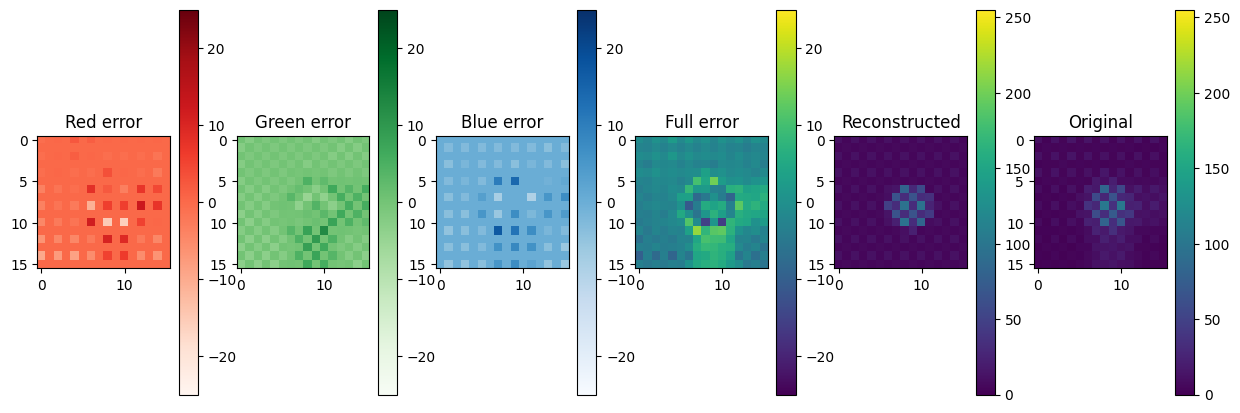

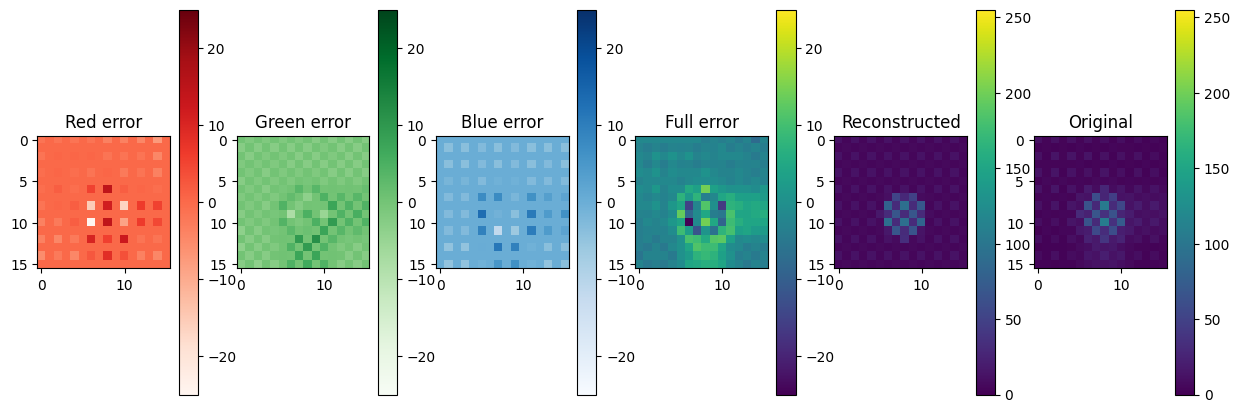

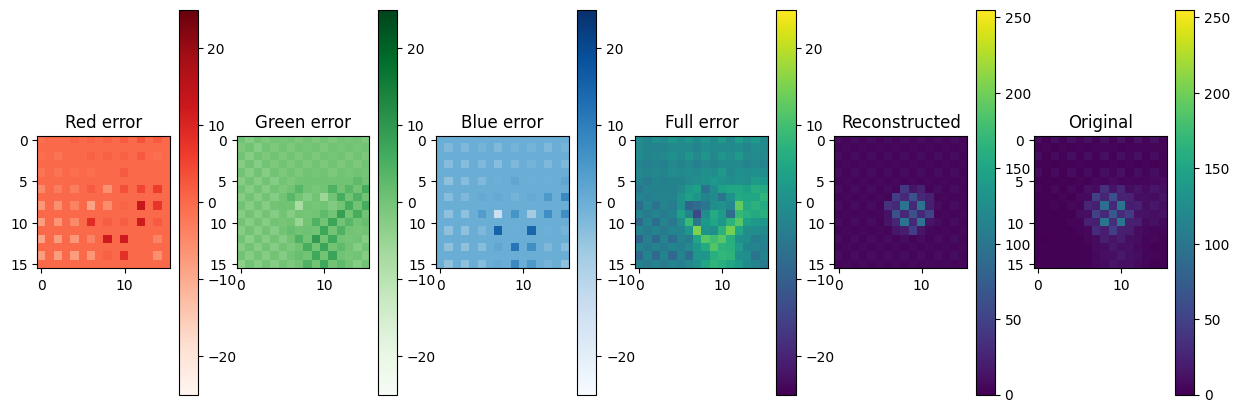

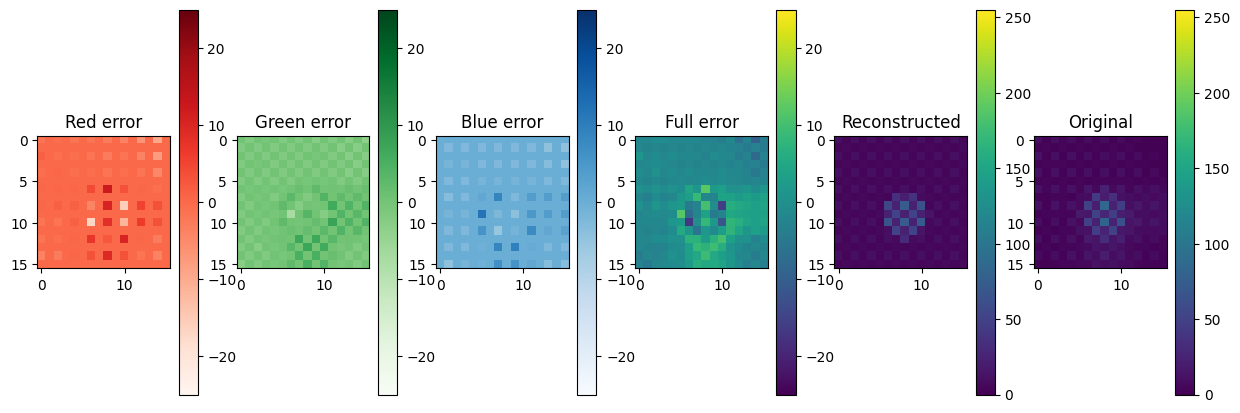

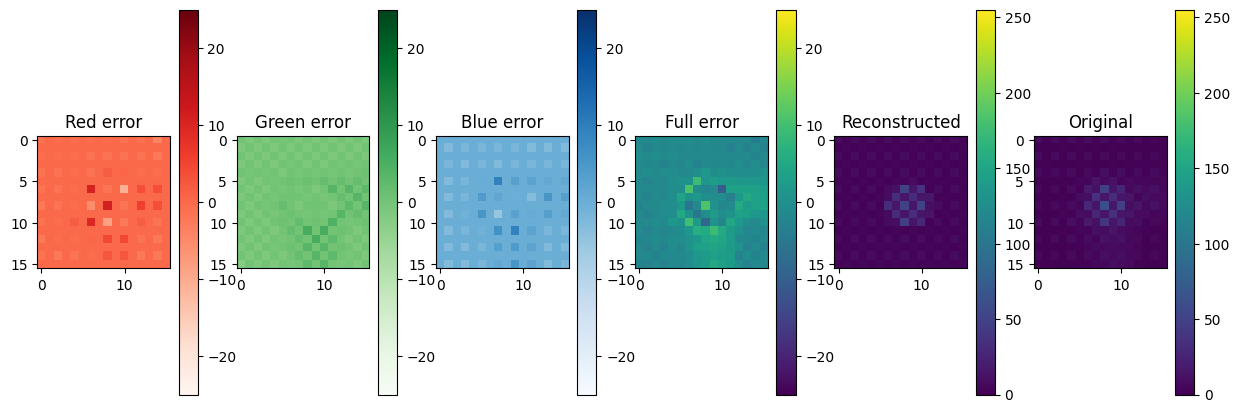

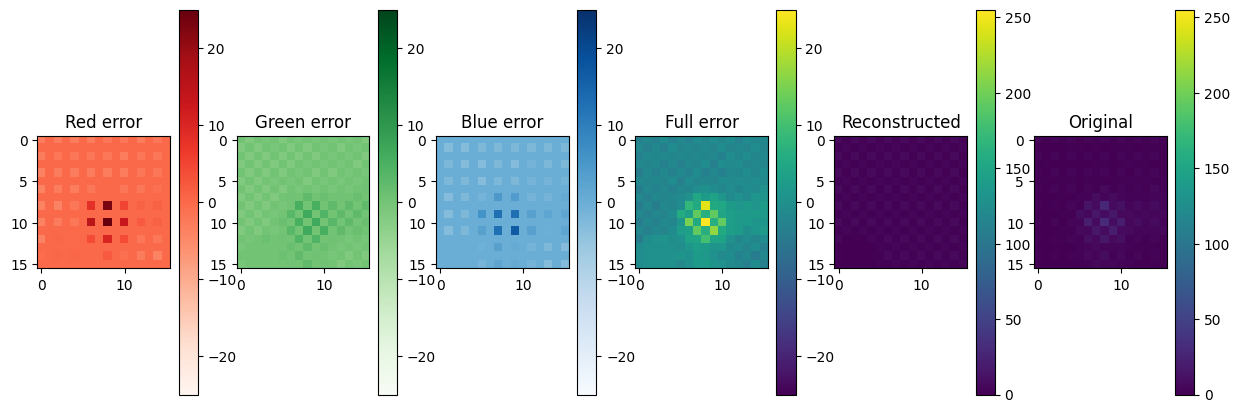

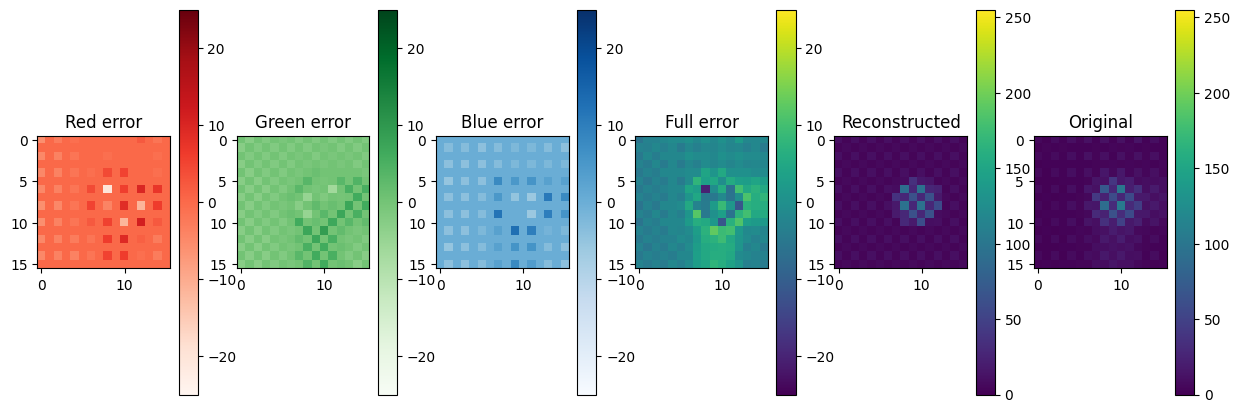

In [161]:
tag0HessInv = []
tag0X = []

for i in range(onlyTag0.shape[0]):
    realImg = getSnipPlot(onlyTag0['Tag'].iloc[i])
    params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])
    res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
                bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))
    pred = np.array(simulate_image(res.x[:2], res.x[2:5], res.x[5:], 2.6, [16,16])).reshape([16,16])
    
    tag0HessInv.append(hessian(temp)(res.x))
    tag0X.append(res.x)

    # Plot error per colour channel
    redGuess, red = getOnlyColour('R', pred, realImg)
    greenGuess, green = getOnlyColour('G', pred, realImg)
    blueGuess, blue = getOnlyColour('B', pred, realImg)
    
    plt.figure(figsize=[15,5])
    plt.subplot(1,6,1)
    plt.imshow(np.array(red - redGuess), clim=[-25,25], cmap='Reds')
    plt.colorbar()
    plt.title("Red error")

    plt.subplot(1,6,2)
    plt.imshow(np.array(green - greenGuess), clim=[-25,25], cmap='Greens')
    plt.colorbar()
    plt.title("Green error")

    plt.subplot(1,6,3)
    plt.imshow(np.array(blue - blueGuess), clim=[-25,25], cmap='Blues')
    plt.colorbar()
    plt.title("Blue error")

    plt.subplot(1,6,4)
    plt.imshow(np.array(realImg - pred), clim=[-25,25])
    plt.colorbar()
    plt.title("Full error")

    plt.subplot(1,6,5)
    plt.imshow(pred, clim=[0,255])
    plt.colorbar()
    plt.title("Reconstructed")

    plt.subplot(1,6,6)
    plt.imshow(realImg, clim=[0,255])
    plt.colorbar()
    plt.title("Original")

Text(0.5, 1.0, 'Plot of 1 tag (in 7 images) in Hue and Saturation')

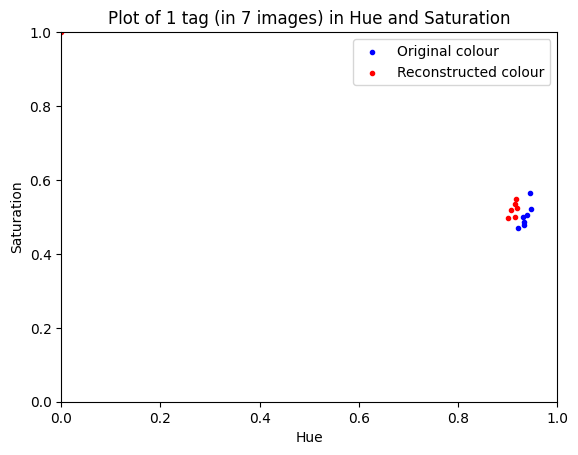

In [162]:
proportionalCols = [x[2:5]/np2.sum(x[2:5]) for x in tag0X]
originalHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(x['Red'], x['Green'], x['Blue']) for _, x in onlyTag0.iterrows()]])
predHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in proportionalCols]])

ax = plt.axes()
plt.scatter(originalHS[:, 0], originalHS[:, 1], c='b', marker='.', label='Original colour')
plt.scatter(predHS[:, 0], predHS[:, 1], c='r', marker='.', label='Reconstructed colour')
ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
plt.legend()
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of 1 tag (in 7 images) in Hue and Saturation')

In [163]:
def getSamples(tagX: list, tagHessInv: list, n: int) -> np.array:
    samples = mvn(tagX[n][2:5], np.linalg.inv(tagHessInv[n][2:5,2:5]), 20)
    return np.array([[h, abs(s)] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in samples]]) 

Text(0.5, 1.0, 'Plot of samples of Gaussian in Hue and Saturation')

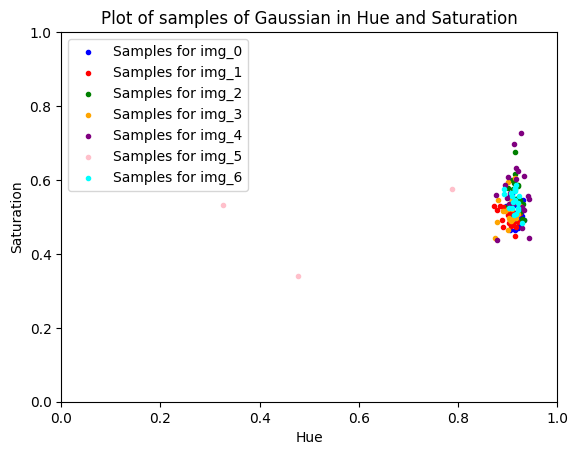

In [164]:
hsSamples = getSamples(tag0X, tag0HessInv, 0)
hsSamples1 = getSamples(tag0X, tag0HessInv, 1)
hsSamples2 = getSamples(tag0X, tag0HessInv, 2)
hsSamples3 = getSamples(tag0X, tag0HessInv, 3)
hsSamples4 = getSamples(tag0X, tag0HessInv, 4)
hsSamples5 = getSamples(tag0X, tag0HessInv, 5)
hsSamples6 = getSamples(tag0X, tag0HessInv, 6)

ax = plt.axes()
ax.set(xlim=(0, 1.0), ylim=(0, 1.0))

plt.scatter(hsSamples[:, 0], hsSamples[:, 1], c='b', marker='.', label='Samples for img_0')
plt.scatter(hsSamples1[:, 0], hsSamples1[:, 1], c='r', marker='.', label='Samples for img_1')
plt.scatter(hsSamples2[:, 0], hsSamples2[:, 1], c='g', marker='.', label='Samples for img_2')
plt.scatter(hsSamples3[:, 0], hsSamples3[:, 1], c='orange', marker='.', label='Samples for img_3')
plt.scatter(hsSamples4[:, 0], hsSamples4[:, 1], c='purple', marker='.', label='Samples for img_4')
plt.scatter(hsSamples5[:, 0], hsSamples5[:, 1], c='pink', marker='.', label='Samples for img_5')
plt.scatter(hsSamples6[:, 0], hsSamples6[:, 1], c='cyan', marker='.', label='Samples for img_6')
plt.legend()
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of samples of Gaussian in Hue and Saturation')

In [165]:
def plotHeatmap(asTuples, asTuples2, scale, third=None):
    """Plot values in a RGB ternary heatmap, with optional third marker."""

    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    tax.scatter(asTuples*scale, marker='x', color='#f00', label='Original', zorder=3)
    tax._redraw_labels()
    tax.scatter(asTuples2*scale, marker='x', color='#000', label='Reconstructed', zorder=3)
    tax._redraw_labels()
    if third != None:
        tax.scatter(third*scale, marker='.', color='#00f', label='Mean', zorder=3)
        tax._redraw_labels()

    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
    tax._redraw_labels()

    tax.ax.legend()
    
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap")
    plt.show()

C:\Users\katie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


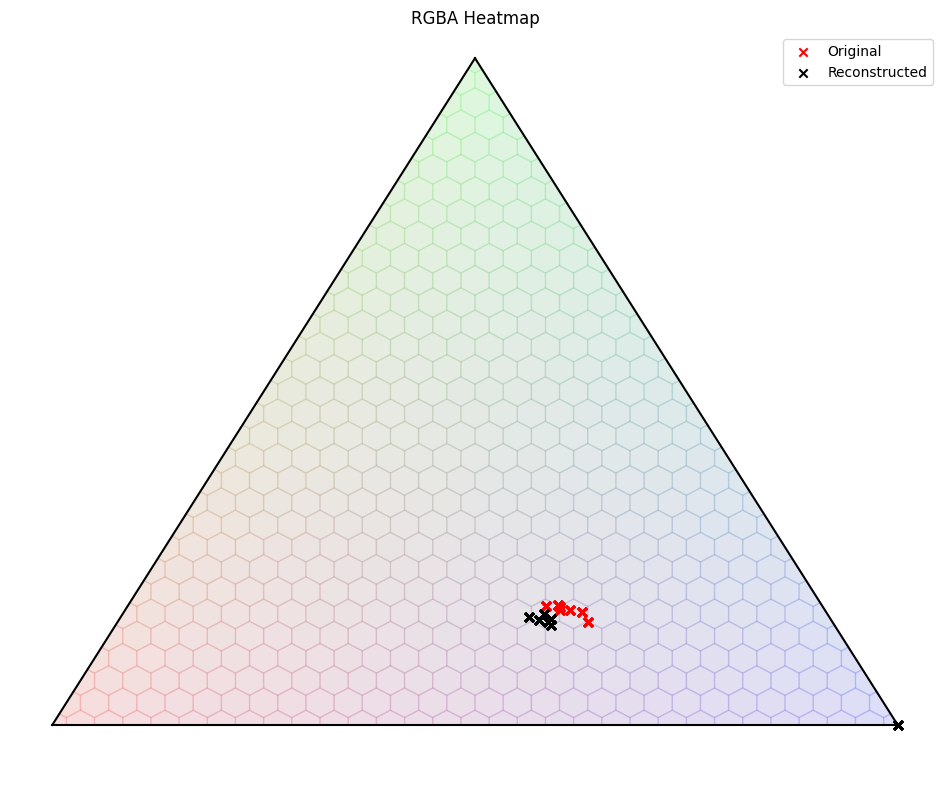

In [166]:
# Plot reconstructed tag0 colours against true (from average pixel values) tag0 colour
originalTuple = [[x['Red']*scale, x['Green']*scale, x['Blue']*scale] for _, x in onlyTag0.iterrows()]
predTuple = [[y[0]*scale, y[1]*scale, y[2]*scale] for y in proportionalCols]
plotHeatmap(originalTuple, predTuple, scale)

# Process all tags

In [24]:
allTagPred = pd.DataFrame(pd.read_pickle("all_tag_predictions.pkl"))
allTagPred

,Label,Tag,Reconstruction,Result
1,0,<__main__.tagClass object at 0x000001F2B01EF210>,"[11.72016, 4.6343055, 11.72016, 4.6343055, 11....","[8.047220354695787, 8.691617613792326, 102.837..."
2,1,<__main__.tagClass object at 0x000001F2B44D8590>,"[16.640305, 11.937861, 16.640305, 11.937861, 1...","[7.587259525822748, 7.219637563379005, 235.541..."
3,2,<__main__.tagClass object at 0x000001F2B44D9CD0>,"[7.8146467, 5.2145624, 7.8146467, 5.2145624, 7...","[9.535182889120323, 8.35447744133174, 42.20767..."
4,3,<__main__.tagClass object at 0x000001F2B44DB350>,"[4.43634, 3.342901, 4.43634, 3.342901, 4.43634...","[8.975128321189073, 7.853904304579828, 84.4275..."
5,4,<__main__.tagClass object at 0x000001F2B44DB8D0>,"[3.7437358, 3.7395382, 3.7437358, 3.7395382, 3...","[12.001745504243114, 9.354130515810132, 15.030..."
...,...,...,...,...
276,35,<__main__.tagClass object at 0x000001F2B065F7D0>,"[7.5147657, 8.009129, 7.5147657, 8.009129, 7.5...","[8.167007414888351, 8.174375940599333, 52.8559..."
277,36,<__main__.tagClass object at 0x000001F2B065FC90>,"[8.242332, 8.795967, 8.242332, 8.795967, 8.242...","[8.524161161302958, 8.004590156959832, 174.329..."
278,37,<__main__.tagClass object at 0x000001F2B065D110>,"[8.065044, 6.0255184, 8.065044, 6.0255184, 8.0...","[8.64258361377473, 9.76496203951905, 129.16473..."
279,38,<__main__.tagClass object at 0x000001F2B065D390>,"[8.277167, 6.1911597, 8.277167, 6.1911597, 8.2...","[7.019852808868246, 9.557501443907846, 165.146..."


In [25]:
def check_zero_ratio(val: list[float]):
    """Return RGB as fractions of total, unless all zero values."""
    zero = all(v == 0 for v in val)
    if zero:
        return np.array(val)
    else:
        return np.array(val/np2.sum(val))

In [59]:
# Process all tags into arrays (grouped by unique tag)
all_by_tag = np2.empty((40,7,3))

for l in range(40):
    all_tag_labeled = allTagPred.loc[allTagPred['Label'] == l]
    all_tags_ = []
    for _, tag in all_tag_labeled.iterrows():
        r = check_zero_ratio(tag['Result'][2:5])
        all_tags_.append(r)
    all_by_tag[l] = np.array(all_tags_)

# RGB heatmaps and HLS plots

In [172]:
def plotHeatmapAll(rgbTuples, labels:list, scale, title):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[14,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    for i in range(len(rgbTuples)):
        colours = ['#888', '#f00', '#e8e', '#65d', '#000']
        if labels[i] < 5:
            marker = 'd'
            c = i
            edge = 'k'
        elif labels[i] < 10:
            marker = 'o'
            c = i-5
            edge = 'k'
        elif labels[i] < 15:
            marker = '>'
            c = i-10
            edge = 'k'
        elif labels[i] < 20:
            marker = 's'
            c = i-15
            edge = 'k'
        elif labels[i] < 25:
            marker = 'x'
            c = i-20
            edge = None
        elif labels[i] < 30:
            marker = '.'
            c = i-25
            edge = None
        elif labels[i] < 35:
            marker = '1'
            c = i-30
            edge = None
        else:
            marker = '+'
            c = i-35
            edge = None
        
        tax.scatter(rgbTuples[i]*scale, marker=marker, color=colours[c], label=f'Tag {labels[i]}',
                    zorder=3, edgecolors=edge)

    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
  
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title(f"RGBA Heatmap for {title}")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(ncol=4, loc='lower left', bbox_to_anchor=(1, 0.5))

    plt.show()

In [173]:
by_tag_og = allTags.copy()
by_tag_og = by_tag_og.sort_values(by=['Label'])
asTuples = [[x.iloc[1], x.iloc[2], x.iloc[3]] for _, x in by_tag_og.iterrows()]
asTuples = np2.array(asTuples).reshape(40,7,3)

Text(0.5, 1.0, 'Plot of all tags by average colour')

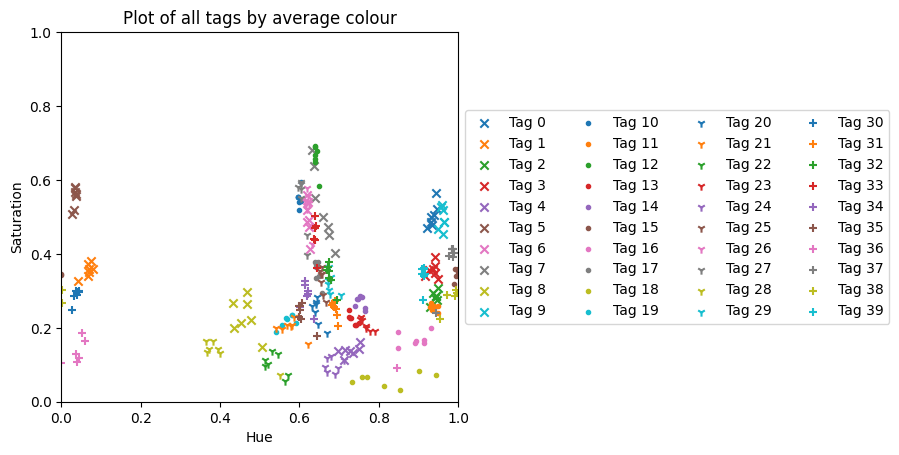

In [174]:
ax = plt.axes()

for label in range(asTuples.shape[0]):
    # Split into different markers based on label for better plotting
    if label < 10:
        marker = 'x'
    elif label < 20:
        marker = '.'
    elif label < 30:
        marker = '1'
    else:
        marker = '+'
    
    # Process RGB values into HLS values (easier to plot for all tags than RGB triangle)
    tagHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in asTuples[label]]])
    plt.scatter(tagHS[:, 0], tagHS[:, 1], marker=marker, label=f'Tag {label}')

ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(ncols=4, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of all tags by average colour')

Text(0.5, 1.0, 'Plot of all tags by reconstructed colour')

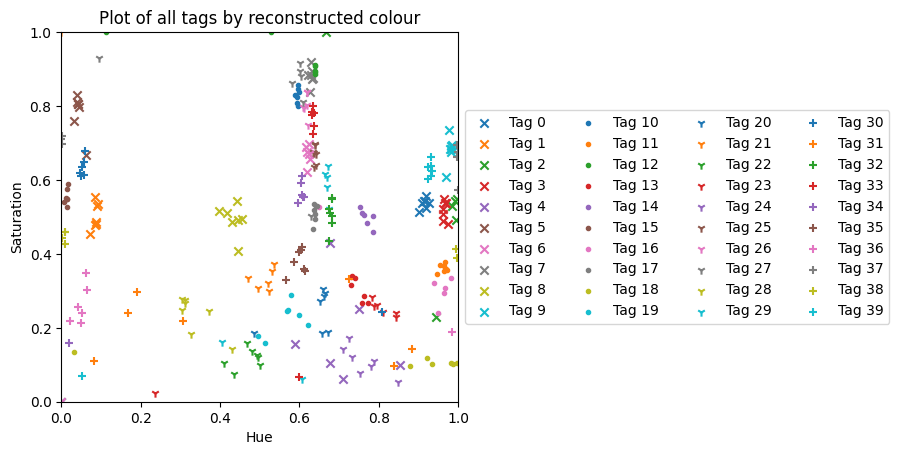

In [170]:
ax = plt.axes()

for label in range(all_by_tag.shape[0]):
    # Split into different markers based on label for better plotting
    if label < 10:
        marker = 'x'
    elif label < 20:
        marker = '.'
    elif label < 30:
        marker = '1'
    else:
        marker = '+'
    
    # Process RGB values into HLS values (easier to plot for all tags than RGB triangle)
    tagHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in all_by_tag[label]]])
    plt.scatter(tagHS[:, 0], tagHS[:, 1], marker=marker, label=f'Tag {label}')

ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(ncols=4, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of all tags by reconstructed colour')

C:\Users\katie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


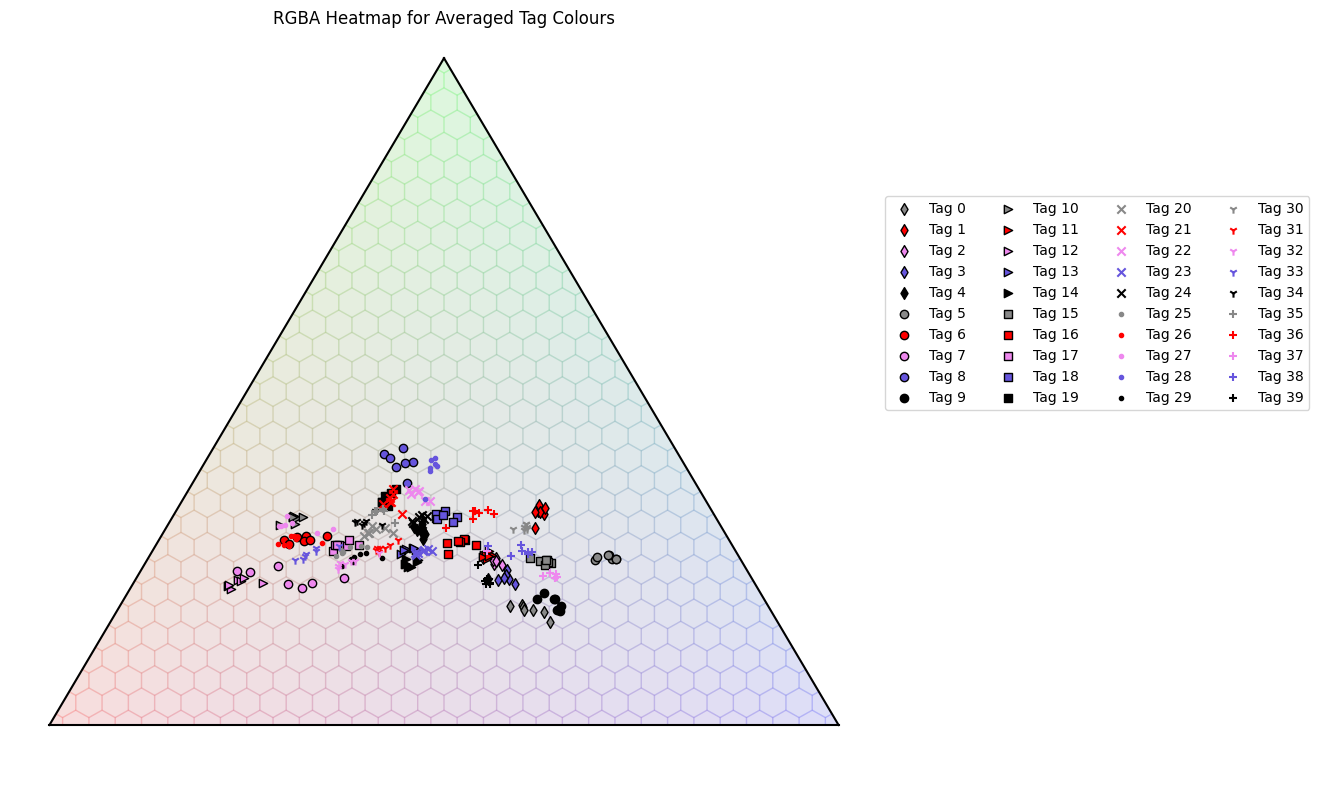

In [175]:
plotHeatmapAll(asTuples, list(range(40)), scale, "Averaged Tag Colours")

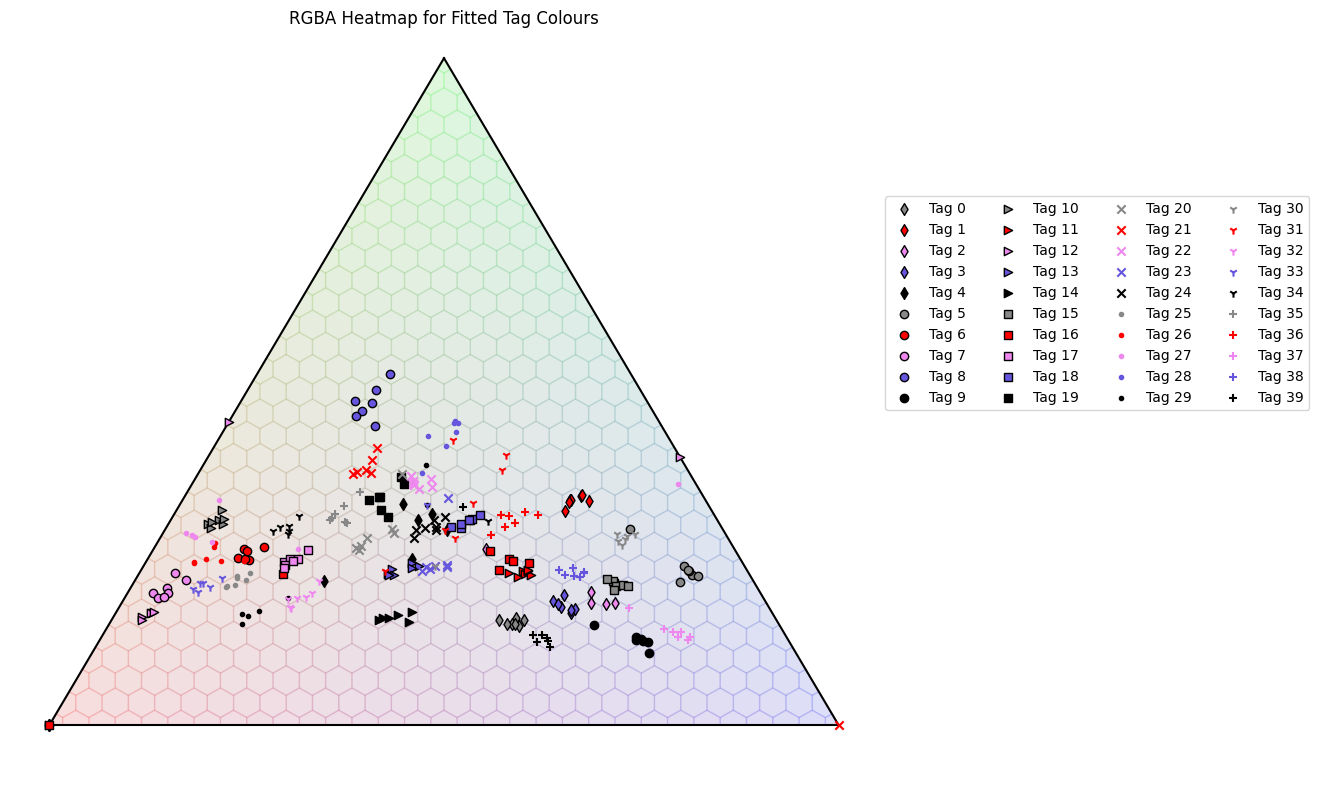

In [176]:
plotHeatmapAll(all_by_tag, list(range(40)), scale, "Fitted Tag Colours")

# Synthetic tests

In [177]:
def synthetic_tag(r: int, g: int, b: int):
    width = 2.5
    centreTag = (ran.randint(6, 10), ran.randint(6, 10)) # randomly selects coords of centre within bounds
    
    X, Y = np2.ogrid[:16, :16] # 16 x 16 matrix
    dist = np2.sqrt((X - centreTag[0])**2 + (Y - centreTag[1])**2)
   
    area = dist <= (width+0.5)
    centre = dist <= width

    # set base matrix (background ran variation below 5)
    redCircle = np2.random.random([16, 16]) * 5
    greenCircle = np2.random.random([16, 16]) * 5
    blueCircle = np2.random.random([16, 16]) * 5
    
    # mimics outer edge being dimmer
    # (0.75+0.25*np.random.rand(16,16))*r*0.8
    for rx in redCircle[area & (centre==False)]:
        rx = (ran.randint(75,100)/100)*r*0.8
    for gx in greenCircle[area & (centre==False)]:
        gx = (ran.randint(75,100)/100)*g*0.8
    for bx in blueCircle[area & (centre==False)]:
        bx = (0.75+0.25*np.random.rand(16,16))*b*0.8

    # centre of tag is brightest
    redCircle[centre] = r
    greenCircle[centre] = g
    blueCircle[centre] = b

    _, redPixels = getOnlyColour('R', np.ones([16, 16]), redCircle)
    _, greenPixels = getOnlyColour('G', np.ones([16, 16]), greenCircle)
    _, bluePixels = getOnlyColour('B', np.ones([16, 16]), blueCircle)

    return np2.where(redPixels == 0, np2.where(bluePixels == 0, greenPixels, bluePixels), redPixels)

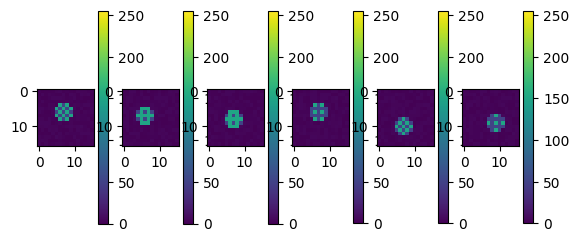

In [178]:
high = 150
low = 50

syntheticTags = [
    synthetic_tag(r=high, g=low, b=high), # purple [150, 50,150]
    synthetic_tag(r=low, g=high, b=high), # cyan   [ 50,150,150]
    synthetic_tag(r=high, g=high, b=low), # orange [150,150, 50]
    synthetic_tag(r=high, g=low, b=low),  # red    [150, 50, 50]
    synthetic_tag(r=low, g=high, b=low),  # green  [ 50,150, 50]
    synthetic_tag(r=low, g=low, b=high)   # blue   [ 50, 50,150]
]

for s in range(len(syntheticTags)):
    plt.subplot(1, len(syntheticTags), s+1)
    plt.imshow(syntheticTags[s], clim=[0,255])
    plt.colorbar()

In [179]:
def testPred(predList, resList):
    params = np2.array([8.0, 8, 100, 50, 20, 5, 4, 3])
    res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
                bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))
    tagCoord, tagBright, bgBright = res.x[:2], res.x[2:5], res.x[5:]
    pred = np.array(simulate_image(tagCoord, tagBright, bgBright, 2.6, [16,16])).reshape([16,16])
    
    predList.append(pred)
    resList.append(res.x)

    return predList, resList

In [180]:
synth_pred = []
synth_res = []
for realImg in syntheticTags:
    synth_pred, synth_res = testPred(synth_pred, synth_res)

C:\Users\katie\AppData\Local\Temp\ipykernel_16424\1993223173.py:3: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


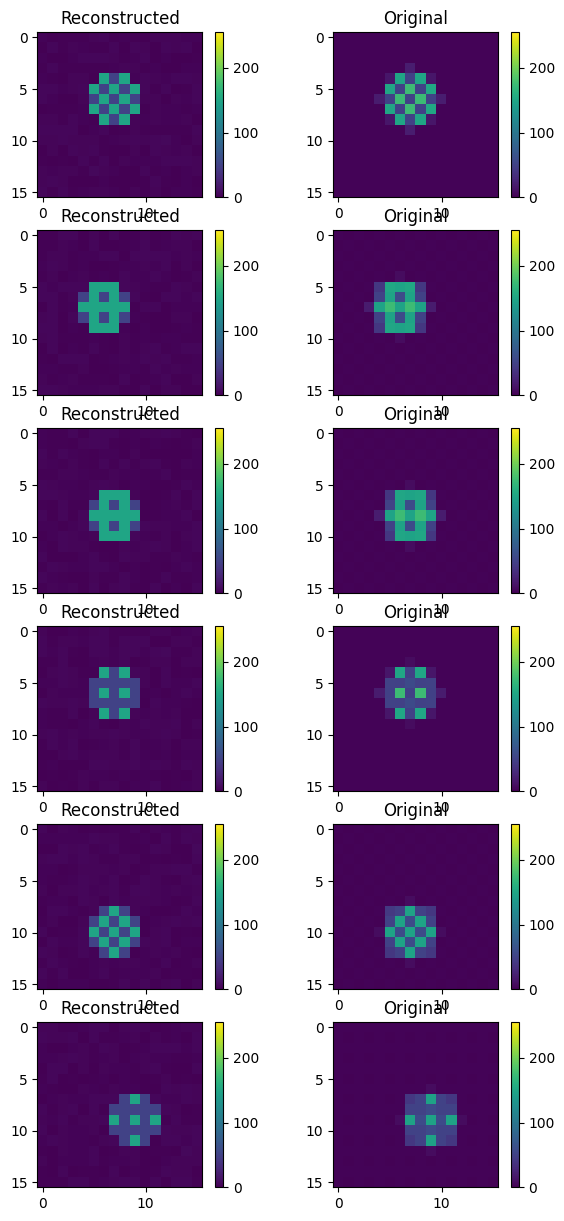

In [181]:
plt.figure(figsize=(7,15))
s = 1
for i in range(0, len(syntheticTags)):
    plt.subplot(6, 2, s)
    plt.imshow(syntheticTags[i], clim=[0,255])
    plt.title("Reconstructed")
    plt.colorbar()

    plt.subplot(6, 2, s+1)
    plt.imshow(synth_pred[i], clim=[0,255])
    plt.title("Original")
    plt.colorbar()
    s+=2

In [182]:
synth_colours = []
for i in range(len(syntheticTags)):
    synth_colours.append(getPixels((0,16,0,16), syntheticTags[i]))

intended_colours = [[150, 50, 150], [50, 150, 150], [150, 150, 50], [150, 50, 50], [50, 150, 50], [50, 50, 150]]
intended_colours = [c/np2.sum(c) for c in intended_colours]
test_colours = [x[2:5]/np2.sum(x[2:5]) for x in synth_res]

In [183]:
def plotHeatmapSynth(actual, reconstr, intended, scale):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)
    
    cols = ['#c7c', '#e80', '#000', '#00f', '#3b3', '#f00']
    i_cols = ['purple', 'orange', 'cyan', 'blue', 'green', 'red']

    for i in range(len(actual)):
        tax.scatter(actual[i]*scale, marker='x', color=cols[i], label=f"Orignal {i_cols[i]}", zorder=3)
        tax.scatter(reconstr[i]*scale, marker='1', color=cols[i], label=f"Reconstructed {i_cols[i]}", zorder=3)
        tax.scatter(intended[i]*scale, marker='.', color=cols[i], label=f"Intended {i_cols[i]}", zorder=3)

    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
  
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap for Synthetic Tags")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

    plt.show()

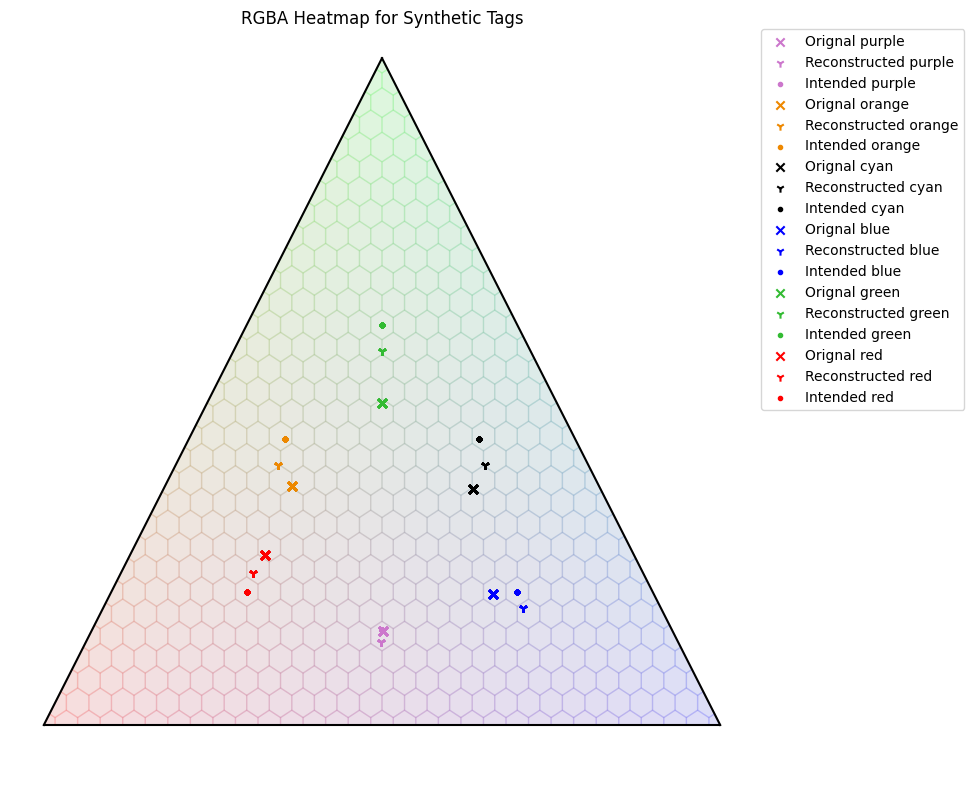

In [184]:
synth_tuple = [[[x[0]*scale, x[1]*scale, x[2]*scale]] for x in synth_colours]
test_tuple = [[[y[0]*scale, y[1]*scale, y[2]*scale]] for y in test_colours]
intended_tuple = [[[z[0]*scale, z[1]*scale, z[2]*scale]] for z in intended_colours]
plotHeatmapSynth(synth_tuple, test_tuple, intended_tuple, scale)

# Predicting

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
def scores(modelPred, actual, name):
    """Calculate predicting scores based on specific metrics."""
    print(name)
    a = accuracy_score(actual, modelPred)
    print("Accuracy: ", a)
    print("F1: ", f1_score(actual, modelPred, average='macro'))
    print("Precision: ", precision_score(actual, modelPred, average='macro', zero_division=np.nan))
    print("Recall: ", recall_score(actual, modelPred, average='macro'))
    print("MSE: ", mean_squared_error(actual, modelPred), "\n")
    return a

In [70]:
knn_a = []
rfc_a = []
gnb_a = []
svc_a = []
clfs = ['40 tags', '38 tags', '37 tags', '35 tags', '40 tags (HLS)']

# Train classifiers on training data and predict test set and return results
test_set = np2.array([all_by_tag[i][6] for i in range(all_by_tag.shape[0])])
train_set_og = np2.array([all_by_tag[i][1:6] for i in range(all_by_tag.shape[0])])
train_set = train_set_og.reshape(200,3)
valid_set = np2.array([all_by_tag[i][0] for i in range(all_by_tag.shape[0])])

train_labels = []
[train_labels.extend(np.ones(5)*i) for i in range(40)]
train_labels = np2.array(train_labels)

## KNN with different neighbours

In [71]:
knn = KNeighborsClassifier(3).fit(train_set, train_labels)
knn_pred = knn.predict(valid_set)
scores(knn_pred, list(range(40)), "KNN - 3N")

knn = KNeighborsClassifier(4).fit(train_set, train_labels)
knn_pred = knn.predict(valid_set)
scores(knn_pred, list(range(40)), "KNN - 4N")

knn = KNeighborsClassifier(5).fit(train_set, train_labels)
knn_pred = knn.predict(valid_set)
scores(knn_pred, list(range(40)), "KNN - 5N")

knn = KNeighborsClassifier(6).fit(train_set, train_labels)
knn_pred = knn.predict(valid_set)
scores(knn_pred, list(range(40)), "KNN - 6N")

knn = KNeighborsClassifier(7).fit(train_set, train_labels)
knn_pred = knn.predict(valid_set)
scores(knn_pred, list(range(40)), "KNN - 7N")

KNN - 3N
Accuracy:  0.825
F1:  0.7708333333333333
Precision:  0.9040404040404041
Recall:  0.825
MSE:  9.3 

KNN - 4N
Accuracy:  0.825
F1:  0.7708333333333333
Precision:  0.9040404040404041
Recall:  0.825
MSE:  14.4 

KNN - 5N
Accuracy:  0.825
F1:  0.775
Precision:  0.9141414141414141
Recall:  0.825
MSE:  9.375 

KNN - 6N
Accuracy:  0.8
F1:  0.7458333333333333
Precision:  0.8737373737373738
Recall:  0.8
MSE:  19.0 

KNN - 7N
Accuracy:  0.8
F1:  0.7458333333333333
Precision:  0.8737373737373738
Recall:  0.8
MSE:  19.0 



0.8

## All 40 (RGB): highest = 85.0%

In [72]:
knn = KNeighborsClassifier(5).fit(train_set, train_labels)
knn_pred = knn.predict(test_set)
knn_a.append(scores(knn_pred, list(range(40)), "KNN")*100)

rfc = RandomForestClassifier().fit(train_set, train_labels)
rfc_pred = rfc.predict(test_set)
rfc_a.append(scores(rfc_pred, list(range(40)), "RFC")*100)

gnb = GaussianNB().fit(train_set, train_labels)
gnb_pred = gnb.predict(test_set)
gnb_a.append(scores(gnb_pred, list(range(40)), "GNB")*100)

svc = SVC().fit(train_set, train_labels)
svm_pred = svc.predict(test_set)
svc_a.append(scores(svm_pred, list(range(40)), "SVC")*100)

KNN
Accuracy:  0.85
F1:  0.8041666666666666
Precision:  0.9215686274509804
Recall:  0.85
MSE:  35.6 

RFC
Accuracy:  0.8
F1:  0.7541666666666667
Precision:  0.8627450980392156
Recall:  0.8
MSE:  35.25 

GNB
Accuracy:  0.675
F1:  0.5958333333333334
Precision:  0.7444444444444446
Recall:  0.675
MSE:  86.075 

SVC
Accuracy:  0.625
F1:  0.5208333333333333
Precision:  0.697530864197531
Recall:  0.625
MSE:  98.475 



## 38 tags: highest = 89.5%

In [76]:
tag38 = [4, 31]

by_tag_all_removed = np.delete(train_set_og, tag38, 0)
by_tag_all_removed = by_tag_all_removed.reshape(190,3)

by_tag_label_removed = np2.array(train_labels)
by_tag_label_removed = np2.delete(by_tag_label_removed, np2.argwhere(np2.isin(by_tag_label_removed, tag38)))

nums = np2.array(list(range(40)))
labels_no1 = np.delete(nums, tag38)
test_set_1 = np.delete(test_set, tag38, 0)

knn = KNeighborsClassifier(5).fit(by_tag_all_removed, by_tag_label_removed)
knn_pred = knn.predict(test_set_1)
knn_a.append(scores(knn_pred, labels_no1, "KNN")*100)

rfc = RandomForestClassifier().fit(by_tag_all_removed, by_tag_label_removed)
rfc_pred = rfc.predict(test_set_1)
rfc_a.append(scores(rfc_pred, labels_no1, "RFC")*100)

gnb = GaussianNB().fit(by_tag_all_removed, by_tag_label_removed)
gnb_pred = gnb.predict(test_set_1)
gnb_a.append(scores(gnb_pred, labels_no1, "GNB")*100)

svc = SVC().fit(by_tag_all_removed, by_tag_label_removed)
svm_pred = svc.predict(test_set_1)
svc_a.append(scores(svm_pred, labels_no1, "SVC")*100)

KNN
Accuracy:  0.8947368421052632
F1:  0.8596491228070174
Precision:  0.9411764705882353
Recall:  0.8947368421052632
MSE:  27.105263157894736 

RFC
Accuracy:  0.868421052631579
F1:  0.8245614035087719
Precision:  0.9242424242424242
Recall:  0.868421052631579
MSE:  26.5 

GNB
Accuracy:  0.7368421052631579
F1:  0.6710526315789473
Precision:  0.8111111111111111
Recall:  0.7368421052631579
MSE:  72.63157894736842 

SVC
Accuracy:  0.6578947368421053
F1:  0.5657894736842105
Precision:  0.7345679012345679
Recall:  0.6578947368421053
MSE:  93.28947368421052 



## 37 tags: highest = 91.9%

In [78]:
tag37 = [2, 4, 31]
by_tag_all_removed2 = np.delete(train_set_og, tag37, 0)
by_tag_all_removed2 = by_tag_all_removed2.reshape(185,3)

by_tag_label_removed2 = np2.array(train_labels)
by_tag_label_removed2 = np2.delete(by_tag_label_removed2, np2.argwhere(np2.isin(by_tag_label_removed2, tag37)))

nums = np2.array(list(range(40)))
labels_no2 = np.delete(nums, tag37)
test_set_2 = np.delete(test_set, tag37, 0)

knn = KNeighborsClassifier(5).fit(by_tag_all_removed2, by_tag_label_removed2)
knn_pred = knn.predict(test_set_2)
knn_a.append(scores(knn_pred, labels_no2, "KNN")*100)

rfc = RandomForestClassifier().fit(by_tag_all_removed2, by_tag_label_removed2)
rfc_pred = rfc.predict(test_set_2)
rfc_a.append(scores(rfc_pred, labels_no2, "RFC")*100)

gnb = GaussianNB().fit(by_tag_all_removed2, by_tag_label_removed2)
gnb_pred = gnb.predict(test_set_2)
gnb_a.append(scores(gnb_pred, labels_no2, "GNB")*100)

svc = SVC().fit(by_tag_all_removed2, by_tag_label_removed2)
svmPred = svc.predict(test_set_2)
svc_a.append(scores(svmPred, labels_no2, "SVC")*100)

KNN
Accuracy:  0.918918918918919
F1:  0.8918918918918919
Precision:  0.9558823529411765
Recall:  0.918918918918919
MSE:  25.135135135135137 

RFC
Accuracy:  0.8918918918918919
F1:  0.8558558558558558
Precision:  0.9393939393939394
Recall:  0.8918918918918919
MSE:  22.89189189189189 

GNB
Accuracy:  0.7567567567567568
F1:  0.6891891891891891
Precision:  0.8390804597701149
Recall:  0.7567567567567568
MSE:  71.89189189189189 

SVC
Accuracy:  0.6756756756756757
F1:  0.581081081081081
Precision:  0.7628205128205128
Recall:  0.6756756756756757
MSE:  93.10810810810811 



## 35 tags: highest = 97.1%

In [80]:
tag35 = [2, 4, 29, 30, 31]
by_tag_all_removed3 = np.delete(train_set_og, tag35, 0)
by_tag_all_removed3 = by_tag_all_removed3.reshape(175,3)

by_tag_label_removed3 = np2.array(train_labels)
by_tag_label_removed3 = np2.delete(by_tag_label_removed3, np2.argwhere(np2.isin(by_tag_label_removed3, tag35)))

nums = np2.array(list(range(40)))
labels_no3 = np.delete(nums, tag35)
test_set_3 = np.delete(test_set, tag35, 0)

knn = KNeighborsClassifier(5).fit(by_tag_all_removed3, by_tag_label_removed3)
knn_pred = knn.predict(test_set_3)
knn_a.append(scores(knn_pred, labels_no3, "KNN")*100)

rfc = RandomForestClassifier().fit(by_tag_all_removed3, by_tag_label_removed3)
rfc_pred = rfc.predict(test_set_3)
rfc_a.append(scores(rfc_pred, labels_no3, "RFC")*100)

gnb = GaussianNB().fit(by_tag_all_removed3, by_tag_label_removed3)
gnb_pred = gnb.predict(test_set_3)
gnb_a.append(scores(gnb_pred, labels_no3, "GNB")*100)

svc = SVC().fit(by_tag_all_removed3, by_tag_label_removed3)
svmPred = svc.predict(test_set_3)
svc_a.append(scores(svmPred, labels_no3, "SVC")*100)

KNN
Accuracy:  0.9428571428571428
F1:  0.9238095238095236
Precision:  0.9696969696969697
Recall:  0.9428571428571428
MSE:  10.17142857142857 

RFC
Accuracy:  0.9714285714285714
F1:  0.9619047619047618
Precision:  0.9852941176470589
Recall:  0.9714285714285714
MSE:  0.45714285714285713 

GNB
Accuracy:  0.7714285714285715
F1:  0.7190476190476189
Precision:  0.8390804597701149
Recall:  0.7714285714285715
MSE:  61.57142857142857 

SVC
Accuracy:  0.7142857142857143
F1:  0.6238095238095238
Precision:  0.8133333333333332
Recall:  0.7142857142857143
MSE:  75.6 



## All 40 (HLS): highest = 80.0%

In [81]:
by_hls = np.array([[h, l, s] for (h, l, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in train_set]])
test_hls = np.array([[h, l, s] for (h, l, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in test_set]])

knn = KNeighborsClassifier(3).fit(by_hls, train_labels)
knn_pred = knn.predict(test_hls)
knn_a.append(scores(knn_pred, list(range(40)), "KNN")*100)

rfc_hls = RandomForestClassifier().fit(by_hls, train_labels)
rfc_pred = rfc_hls.predict(test_hls)
rfc_a.append(scores(rfc_pred, list(range(40)), "RFC")*100)

gnb = GaussianNB().fit(by_hls, train_labels)
gnb_pred = gnb.predict(test_hls)
gnb_a.append(scores(gnb_pred, list(range(40)), "GNB")*100)

svc = SVC().fit(by_hls, train_labels)
svmPred = svc.predict(test_hls)
svc_a.append(scores(svmPred, list(range(40)), "SVC")*100)

KNN
Accuracy:  0.75
F1:  0.6791666666666666
Precision:  0.8333333333333333
Recall:  0.75
MSE:  59.375 

RFC
Accuracy:  0.8
F1:  0.7458333333333333
Precision:  0.8737373737373737
Recall:  0.8
MSE:  56.3 

GNB
Accuracy:  0.7
F1:  0.6291666666666667
Precision:  0.7944444444444445
Recall:  0.7
MSE:  88.15 

SVC
Accuracy:  0.525
F1:  0.4058333333333334
Precision:  0.6195652173913043
Recall:  0.525
MSE:  125.3 



## Comparison plot

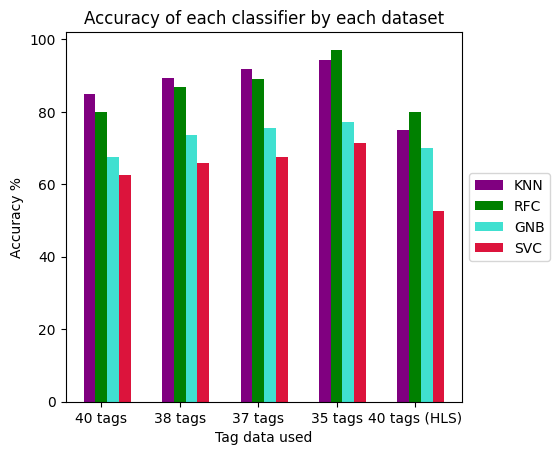

In [115]:
width = 0.15

br1 = np2.arange(len(knn_a))
br2 = [x + width for x in br1]
br3 = [x + width for x in br2]
br4 = [x + width for x in br3]

ax = plt.axes()
plt.bar(br1, knn_a, color='purple', width=width, label='KNN')
plt.bar(br2, rfc_a, color='green', width=width, label='RFC')
plt.bar(br3, gnb_a, color='turquoise', width=width, label='GNB')
plt.bar(br4, svc_a, color='crimson', width=width, label='SVC')

plt.title("Accuracy of each classifier by each dataset")
plt.xlabel("Tag data used")
plt.ylabel("Accuracy %")
plt.xticks([r + width for r in range(len(clfs))], clfs)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## KNN accuracy by number of tags (manual selection)

KNN
Accuracy:  0.9444444444444444
F1:  0.9259259259259258
Precision:  0.9705882352941176
Recall:  0.9444444444444444
MSE:  24.47222222222222 

KNN
Accuracy:  0.8717948717948718
F1:  0.8333333333333334
Precision:  0.9362745098039217
Recall:  0.8717948717948718
MSE:  32.17948717948718 



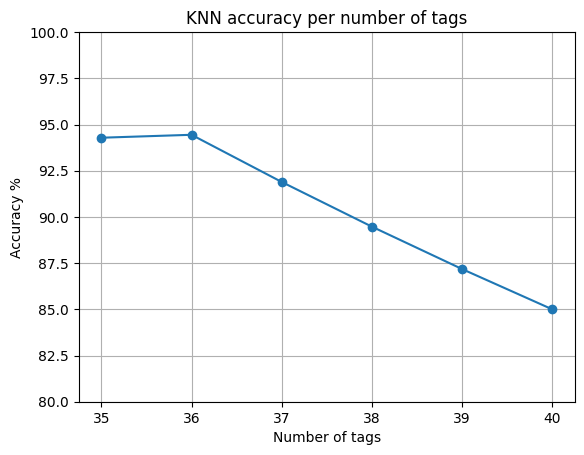

In [84]:
tag36 = [2, 4, 29, 31]
tag39 = [31]

by_tag_all_removed3 = np.delete(train_set_og, tag36, 0)
by_tag_all_removed3 = by_tag_all_removed3.reshape(180,3)

by_tag_label_removed3 = np2.array(train_labels)
by_tag_label_removed3 = np2.delete(by_tag_label_removed3, np2.argwhere(np2.isin(by_tag_label_removed3, tag36)))

nums = np2.array(list(range(40)))
labels_no3 = np.delete(nums, tag36)
test_set_3 = np.delete(test_set, tag36, 0)

knn = KNeighborsClassifier(5).fit(by_tag_all_removed3, by_tag_label_removed3)
knn_pred = knn.predict(test_set_3)
at36 = scores(knn_pred, labels_no3, "KNN")*100

by_tag_all_removed3 = np.delete(train_set_og, tag39, 0)
by_tag_all_removed3 = by_tag_all_removed3.reshape(195,3)

by_tag_label_removed3 = np2.array(train_labels)
by_tag_label_removed3 = np2.delete(by_tag_label_removed3, np2.argwhere(np2.isin(by_tag_label_removed3, tag39)))

nums = np2.array(list(range(40)))
labels_no3 = np.delete(nums, tag39)
test_set_3 = np.delete(test_set, tag39, 0)

knn = KNeighborsClassifier(5).fit(by_tag_all_removed3, by_tag_label_removed3)
knn_pred = knn.predict(test_set_3)
at39 = scores(knn_pred, labels_no3, "KNN")*100

names = [40, 39, 38, 37, 36, 35]
plot_knn = [knn_a[0], at39, knn_a[1], knn_a[2], at36, knn_a[3]]
plot_knn.reverse()
names.reverse()

plt.plot(names, plot_knn, marker='o')
plt.grid()
plt.ylim((80,100))
plt.xlabel("Number of tags")
plt.ylabel("Accuracy %")
plt.title("KNN accuracy per number of tags")
plt.show()

KNN - test img = 0
Accuracy:  0.85
F1:  0.7999999999999999
Precision:  0.9117647058823529
Recall:  0.85
MSE:  28.5 

KNN - test img = 1
Accuracy:  0.8
F1:  0.7374999999999999
Precision:  0.8854166666666667
Recall:  0.8
MSE:  40.525 

KNN - test img = 2
Accuracy:  0.825
F1:  0.7708333333333333
Precision:  0.904040404040404
Recall:  0.825
MSE:  30.625 

KNN - test img = 3
Accuracy:  0.825
F1:  0.7666666666666666
Precision:  0.8939393939393939
Recall:  0.825
MSE:  29.125 

KNN - test img = 4
Accuracy:  0.85
F1:  0.7999999999999999
Precision:  0.9117647058823529
Recall:  0.85
MSE:  29.1 

[85.0, 80.0, 82.5, 82.5, 85.0, 85.0]


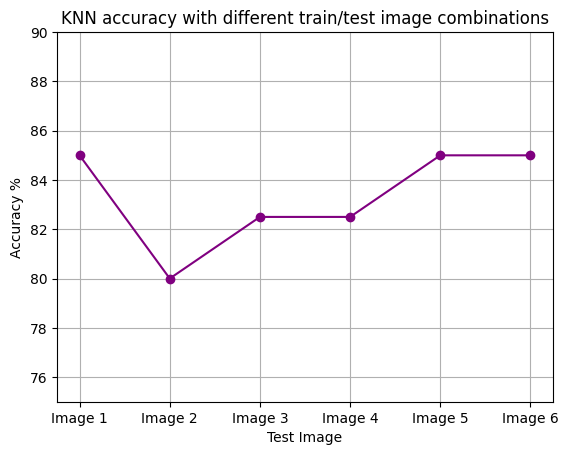

In [88]:
img_acc = []
for i in range(5):
    by_diff_img = train_set_og.copy()
    new_test = [x[i] for x in by_diff_img]

    for x in range(by_diff_img.shape[0]):
        by_diff_img[x][i] = test_set[x]

    by_diff_img = by_diff_img.reshape(200,3)
    knn = KNeighborsClassifier(5).fit(by_diff_img, train_labels)
    knn_pred = knn.predict(new_test)
    img_acc.append(scores(knn_pred, list(range(40)), f"KNN - test img = {i}")*100)

img_acc.append(knn_a[0])
imgs = [f"Image {i}" for i in range(1,7)]
print(img_acc)
plt.plot(imgs, img_acc, marker='o', c='purple')
plt.grid()
plt.ylim((75,90))
plt.xlabel("Test Image")
plt.ylabel("Accuracy %")
plt.title("KNN accuracy with different train/test image combinations")
plt.show()

In [111]:
tag_numbers = [tag35, tag36, tag37, tag38, tag39]
img_accuracies = [[], [], [], [], []]
tag_shape = [175, 180, 185, 190, 195]
for i in range(5):
    this_img = []
    by_diff_img = train_set_og.copy()
    new_test = [x[i] for x in by_diff_img]

    for x in range(by_diff_img.shape[0]):
        by_diff_img[x][i] = test_set[x]
    
    for j in range(5):
        subset_img = np.delete(train_set_og, tag_numbers[j], 0)
        subset_labels = np2.delete(train_labels, np2.argwhere(np2.isin(train_labels, tag_numbers[j])))
        labels_ = np.delete(np2.array(list(range(40))), tag_numbers[j])
        test_set_ = np.delete(new_test, tag_numbers[j], 0)
        
        subset_img = subset_img.reshape(tag_shape[j],3)
        knn = KNeighborsClassifier(5).fit(subset_img, subset_labels)
        knn_pred = knn.predict(test_set_)
        img_accuracies[i].append(scores(knn_pred, labels_, f"KNN - img = {i}, tags = {35+j}")*100)

img_accuracies.append(plot_knn[:-1])
for n in range(len(img_accuracies)):
    img_accuracies[n].append(img_acc[n])

KNN - img = 0, tags = 35
Accuracy:  0.9428571428571428
F1:  0.9238095238095236
Precision:  0.9696969696969697
Recall:  0.9428571428571428
MSE:  10.17142857142857 

KNN - img = 0, tags = 36
Accuracy:  0.9444444444444444
F1:  0.9259259259259258
Precision:  0.9705882352941176
Recall:  0.9444444444444444
MSE:  24.47222222222222 

KNN - img = 0, tags = 37
Accuracy:  0.918918918918919
F1:  0.8918918918918919
Precision:  0.9558823529411765
Recall:  0.918918918918919
MSE:  25.135135135135137 

KNN - img = 0, tags = 38
Accuracy:  0.8947368421052632
F1:  0.8596491228070174
Precision:  0.9411764705882353
Recall:  0.8947368421052632
MSE:  27.105263157894736 

KNN - img = 0, tags = 39
Accuracy:  0.8717948717948718
F1:  0.8333333333333334
Precision:  0.9362745098039217
Recall:  0.8717948717948718
MSE:  32.17948717948718 

KNN - img = 1, tags = 35
Accuracy:  0.9428571428571428
F1:  0.9238095238095236
Precision:  0.9696969696969697
Recall:  0.9428571428571428
MSE:  10.17142857142857 

KNN - img = 1, t

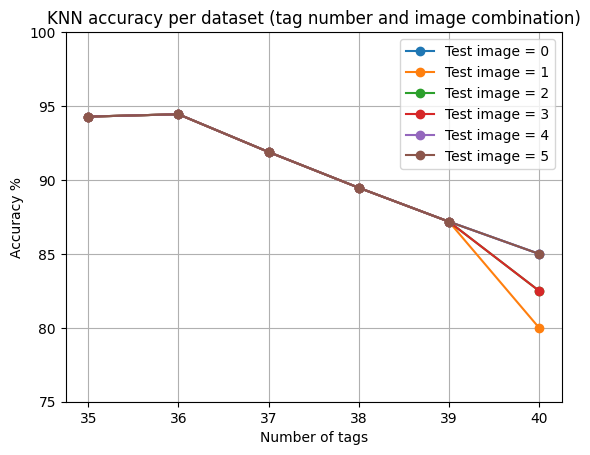

In [114]:
plt.figure()
for n in range(len(img_accuracies)):
    plt.plot(names, img_accuracies[n], marker='o', label=f'Test image = {n}')
plt.grid()
plt.ylim((75,100))
plt.xlabel("Number of tags")
plt.ylabel("Accuracy %")
plt.title("KNN accuracy per dataset (tag number and image combination)")
plt.legend()
plt.show()